# Solving OpenAI Gym PongNoFrameskip-v4 problem

    Pong-v0
    Maximize your score in the Atari 2600 game Pong. In this environment,
    the observation is an RGB image of the screen, which is an array 
    of shape (210, 160, 3) Each action is repeatedly performed for a duration of 
    kk frames, where kk is uniformly sampled from \{2, 3, 4\}{2,3,4}.
    

#### Reinforcement techniques used
- Deep Q-Network (DQN)
- Double DQN (DDQN)
- Dueling DQN
- Dueling Double DQN (DDDQN)

In [2]:
import os
import gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

import matplotlib.pyplot as plt

from utils import plot_learning_curve, make_env
from replay_memory import ReplayBuffer
from agents import DQNAgent, DDQNAgent, DuelingDQNAgent, DuelingDDQNAgent

import warnings
warnings.filterwarnings("ignore")

In [3]:
env = make_env('PongNoFrameskip-v4')

In [25]:
best_score = -np.inf # results in saving the model right away
load_checkpoint = False
#n_games = 500
n_games = 100

### DQN

In [5]:
agent = DQNAgent(gamma=0.99, epsilon=1.0, lr=1e-4, 
                 input_dims=(env.observation_space.shape),
                 n_actions=env.action_space.n, 
                 mem_size=10000, #50000, # if at least 16 GB of RAM
                 eps_min=0.1, 
                 batch_size=32, 
                 replace=1000, # matter of hours
                 eps_dec=1e-5, # get epsilon down to 0.1 in around 100K steps
                 chkpt_dir='models/', # do mkdir beforehand 
                 algo='DQNAgent', # to construct appropriate model file
                 env_name='PongNoFrameskip-v4' # environment name
                )
if load_checkpoint: # handle check point
    agent.load_models() # False in training mode

In [6]:
#agent_ = getattr(Agents, algo) # algo type string
#agent = agent_(
#                 gamma=0.99, epsilon=1.0, lr=1e-4, 
#                 input_dims=(env.observation_space.shape),
#                 n_actions=env.action_space.n, 
#                 mem_size=10000, #50000, # if at least 16 GB of RAM
#                 eps_min=0.1, 
#                 batch_size=32, 
#                 replace=1000, # matter of hours
#                 eps_dec=1e-5, # get epsilon down to 0.1 in around 100K steps
#                 chkpt_dir='models/', # do mkdir beforehand 
#                 algo='DQNAgent', # to construct appropriate model file
#                 env_name='PongNoFrameskip-v4'
#              )

In [7]:
fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) + '_' + str(n_games) + 'games'              
figure_file = 'plots/' + fname + '.png'

n_steps = 0 # for debug purposes
scores, eps_history, steps_array = [], [], [] # to keep track of scores and epsilon history for the plotting

In [8]:
%%time
# play the game
for i in range(n_games):
    done = False
    observation = env.reset()
    score = 0
    
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action, 
                                   reward, observation_, int(done))
            agent.learn()
        observation = observation_
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])
    print('episode: ', i,'score: ', score,
          'average score %.1f' % avg_score, 'best score %.2f' % best_score,
          'epsilon %.2f' % agent.epsilon, 'steps', n_steps)

    if avg_score > best_score:
        #if not load_checkpoint:
        #    agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)
    
    if load_checkpoint and n_steps >= 18000:
        break

episode:  0 score:  -20.0 average score -20.0 best score -inf epsilon 1.00 steps 946
CPU times: user 9min 19s, sys: 17.3 s, total: 9min 36s
Wall time: 1min 26s


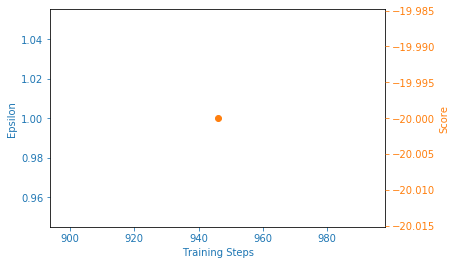

In [9]:
#x = [i+1 for i in range(len(scores))]
#plot_learning_curve(x,  scores, eps_history, figure_file)
plot_learning_curve(steps_array, scores, eps_history, figure_file)

### Double DQN

In [10]:
agent = DDQNAgent(gamma=0.99, epsilon=1.0, lr=0.0001,
                     input_dims=(env.observation_space.shape),
                     n_actions=env.action_space.n, mem_size=50000, eps_min=0.1,
                     batch_size=32, replace=10000, eps_dec=1e-5,
                     chkpt_dir='models/', algo='DDQNAgent',
                     env_name='PongNoFrameskip-v4')

if load_checkpoint:
    agent.load_models()

In [11]:
fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) +'_' \
            + str(n_games) + 'games'
figure_file = 'plots/' + fname + '.png'

In [12]:
n_steps = 0
scores, eps_history, steps_array = [], [], []

In [13]:
# play the game
for i in range(n_games):
    done = False
    observation = env.reset()

    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action,
                                   reward, observation_, int(done))
            agent.learn()
        observation = observation_
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])
    print('episode: ', i,'score: ', score,
          ' average score %.1f' % avg_score, 'best score %.2f' % best_score,
          'epsilon %.2f' % agent.epsilon, 'steps', n_steps)

    if avg_score > best_score:
        #if not load_checkpoint:
        #    agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)
    if load_checkpoint and n_steps >= 18000:
        break

episode:  0 score:  -21.0  average score -21.0 best score -20.00 epsilon 0.99 steps 880


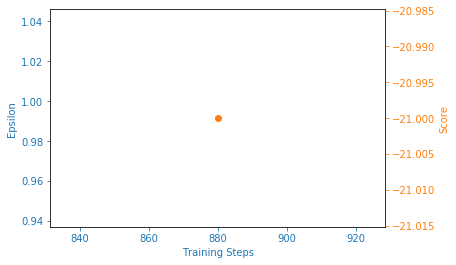

In [14]:
#x = [i+1 for i in range(len(scores))]
#plot_learning_curve(x,  scores, eps_history, figure_file)
plot_learning_curve(steps_array, scores, eps_history, figure_file)

### Dueling DQN

In [15]:
agent = DuelingDQNAgent(gamma=0.99, epsilon=1.0, lr=0.0001,
                     input_dims=(env.observation_space.shape),
                     n_actions=env.action_space.n, mem_size=50000, eps_min=0.1,
                     batch_size=32, replace=10000, eps_dec=1e-5,
                     chkpt_dir='models/', algo='DuelingDQNAgent',
                     env_name='PongNoFrameskip-v4')

if load_checkpoint:
    agent.load_models()

In [16]:
fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) +'_' \
            + str(n_games) + 'games'
figure_file = 'plots/' + fname + '.png'

In [17]:
n_steps = 0
scores, eps_history, steps_array = [], [], []

In [18]:
# play the game
for i in range(n_games):
    done = False
    observation = env.reset()
    score = 0
        
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action,
                                   reward, observation_, int(done))
            agent.learn()
        observation = observation_
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])
    print('episode: ', i,'score: ', score,
          ' average score %.1f' % avg_score, 'best score %.2f' % best_score,
          'epsilon %.2f' % agent.epsilon, 'steps', n_steps)

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)
    if load_checkpoint and n_steps >= 18000:
        break

episode:  0 score:  -20.0  average score -20.0 best score -20.00 epsilon 0.99 steps 961


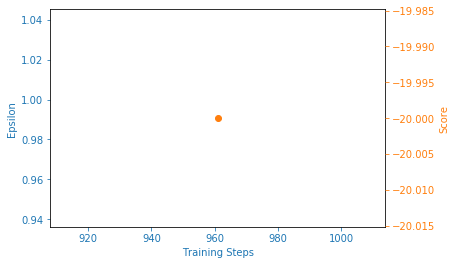

In [19]:
#x = [i+1 for i in range(len(scores))]
#plot_learning_curve(x,  scores, eps_history, figure_file)
plot_learning_curve(steps_array, scores, eps_history, figure_file)

### Dueling Double DQN

In [26]:
agent = DuelingDDQNAgent(gamma=0.99, epsilon=1.0, lr=0.0001,
                     input_dims=(env.observation_space.shape),
                     n_actions=env.action_space.n, mem_size=50000, eps_min=0.1,
                     batch_size=32, replace=10000, eps_dec=1e-5,
                     chkpt_dir='models/', algo='DuelingDDQNAgent',
                     env_name='PongNoFrameskip-v4')

if load_checkpoint:
    agent.load_models()

In [27]:
fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) +'_' \
            + str(n_games) + 'games'
figure_file = 'plots/' + fname + '.png'

In [28]:
n_steps = 0
scores, eps_history, steps_array = [], [], []

In [ ]:
# play the game
for i in range(n_games):
    done = False
    observation = env.reset()
    score = 0
        
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action,
                                   reward, observation_, int(done))
            agent.learn()
        observation = observation_
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])
    print('episode: ', i,'score: ', score,
          ' average score %.1f' % avg_score, 'best score %.2f' % best_score,
          'epsilon %.2f' % agent.epsilon, 'steps', n_steps)

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)
    if load_checkpoint and n_steps >= 18000:
        break

In [ ]:
#x = [i+1 for i in range(len(scores))]
#plot_learning_curve(x,  scores, eps_history, figure_file)
plot_learning_curve(steps_array, scores, eps_history, figure_file)

https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py